# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Необходимо научиться определять рыночную стоимость объектов недвижимости, установить параметры, которые позволят построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма.

**План исследования объявлений о продаже квартир:**

1) Загрузить данные из архива объявлений за несколько лет о продаже квартир в Санкт-Петербурге и соседних населённых пунктах и выволнить преобработку данных (обработать пропщенные значения, привести тип данных в порядок, выявить неявные дубликаты и обработать их, найти и устранить редкие и выбивающиеся значения и аномалии)

2) Определить и добавить дополнительные столбцы необходимые для более детального анализа данных (например, разбить дату публикации объявлений на день недели, месяц, год, сгруппировать этажи квартир и т.д.)

3) Изучить по отдельности значения каждого столбца.

4) Выявить и изучить зависимости цены недвижимости от различных параметров.

5) Написать промежуточные и общий вывод про результатам исследования.


### Откроем файл с данными и изучим общую информацию. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

try:
    data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv', sep='\t')

data.info() #выведем общую информацию о датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

array([[<AxesSubplot:title={'center':'total_images'}>,
        <AxesSubplot:title={'center':'last_price'}>,
        <AxesSubplot:title={'center':'total_area'}>,
        <AxesSubplot:title={'center':'rooms'}>],
       [<AxesSubplot:title={'center':'ceiling_height'}>,
        <AxesSubplot:title={'center':'floors_total'}>,
        <AxesSubplot:title={'center':'living_area'}>,
        <AxesSubplot:title={'center':'floor'}>],
       [<AxesSubplot:title={'center':'kitchen_area'}>,
        <AxesSubplot:title={'center':'balcony'}>,
        <AxesSubplot:title={'center':'airports_nearest'}>,
        <AxesSubplot:title={'center':'cityCenters_nearest'}>],
       [<AxesSubplot:title={'center':'parks_around3000'}>,
        <AxesSubplot:title={'center':'parks_nearest'}>,
        <AxesSubplot:title={'center':'ponds_around3000'}>,
        <AxesSubplot:title={'center':'ponds_nearest'}>],
       [<AxesSubplot:title={'center':'days_exposition'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], d

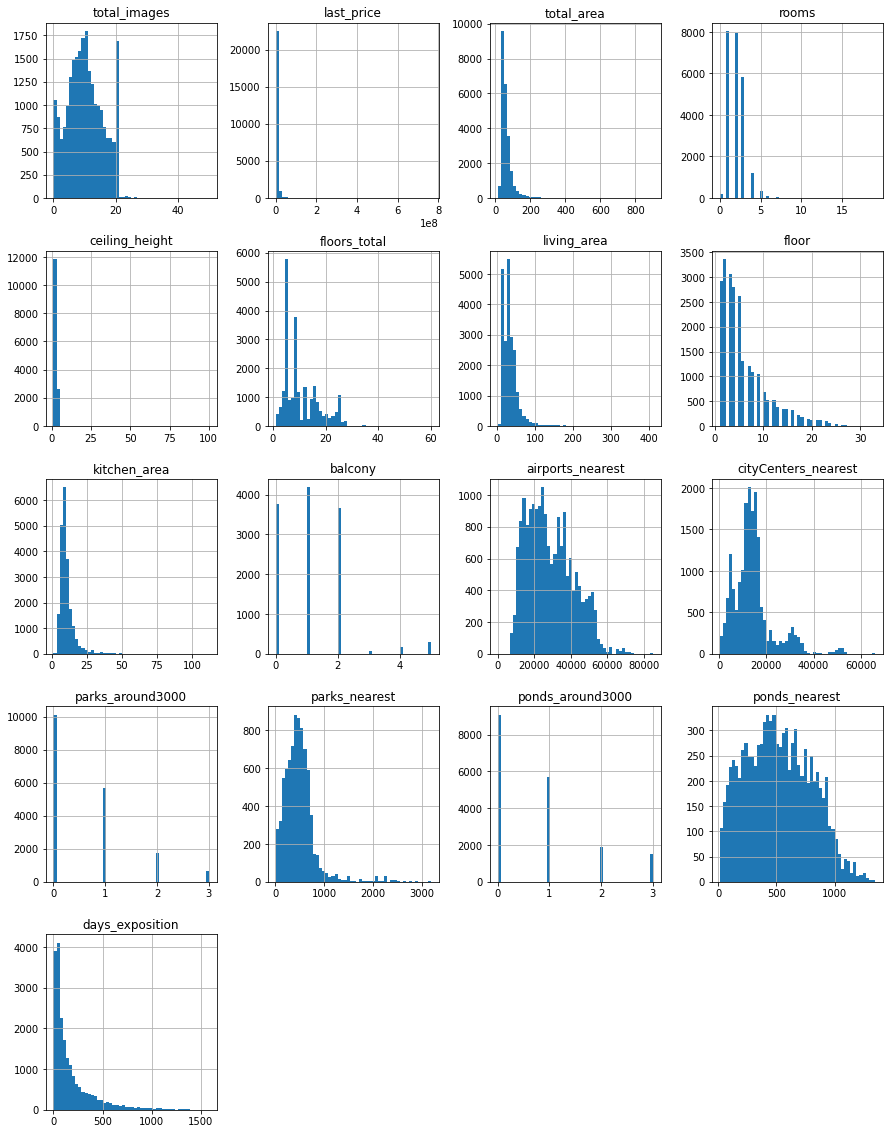

In [2]:
data.hist(figsize=(15, 20), bins=50) #построим гистограммы для каждого столбца

In [3]:
print(data.head(10)) #выведем данные столбцов датафрейма

   total_images  last_price  total_area first_day_exposition  rooms  \
0            20  13000000.0      108.00  2019-03-07T00:00:00      3   
1             7   3350000.0       40.40  2018-12-04T00:00:00      1   
2            10   5196000.0       56.00  2015-08-20T00:00:00      2   
3             0  64900000.0      159.00  2015-07-24T00:00:00      3   
4             2  10000000.0      100.00  2018-06-19T00:00:00      2   
5            10   2890000.0       30.40  2018-09-10T00:00:00      1   
6             6   3700000.0       37.30  2017-11-02T00:00:00      1   
7             5   7915000.0       71.60  2019-04-18T00:00:00      2   
8            20   2900000.0       33.16  2018-05-23T00:00:00      1   
9            18   5400000.0       61.00  2017-02-26T00:00:00      3   

   ceiling_height  floors_total  living_area  floor is_apartment  ...  \
0            2.70          16.0        51.00      8          NaN  ...   
1             NaN          11.0        18.60      1          NaN  ...   

### Предобработка данных

**2.1 Работа с пропущенными значениями в столбцах**

In [4]:
data.isna().sum() #определим количество пропусков в каждом столбце

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

- Наибольшее количество пропусков в столбце 'is_apartment', вероятно это связано с тем пользователи просто не указывали, что квартира не апартамент, заполним пропущенные строки значением False.
- Также большое количество пропусков есть в столбце 'balcony', вероятно пользователи не заносили значения тaм, где не было балкона, тогда заполним пропуски значением 0 и переведем значения столбца из типа данных object в int.
- Аналогичная ситуация со столбцами количества парков и водоемов в радиусе 3000 м: 'parks_around3000' и 'ponds_around3000'. Заполним пропуски значением 0 и изменим тип данных с float на int. 
- Также значительное количество пропусков есть в столбцах 'parks_nearest', 'ponds_nearest' (расстояния до ближайшего парка и водоема), однако это связазно с тем, что в населенном пункте нет парков и водоемов. эта гипотеза проверена выводом на экран сводной таблицы с количеством пропусков по столбцам 'parks_nearest' и 'ponds_nearest' сгруппировав при этом по столбцам 'parks_around3000' и 'ponds_around3000', соответственно.

In [5]:
#заполнение пропусков в столбцах 'is_apartment', 'balcony', 'parks_around3000' и 'ponds_around3000'

data['is_apartment'] = data['is_apartment'].fillna(False)

data['balcony'] = data['balcony'].fillna(0)
data['balcony'] = data['balcony'].astype('int')

data['parks_around3000'] = data['parks_around3000'].fillna(0)
data['parks_around3000'] = data['parks_around3000'].astype('int')

data['ponds_around3000'] = data['ponds_around3000'].fillna(0)
data['ponds_around3000'] = data['ponds_around3000'].astype('int')

#Выведем на экран сводную таблицу с количеством пропусков по столбцам 'parks_nearest' и 'ponds_nearest' 
#сгруппировав при этом по столбцам 'parks_around3000' и 'ponds_around3000', соответственно.
print(data.groupby('parks_around3000')['parks_nearest'].agg(lambda s: s.isna().sum()))
print(data.groupby('ponds_around3000')['ponds_nearest'].agg(lambda s: s.isna().sum()))
#пропуски есть только там где нет парков и водоемов.

data.isna().sum()

parks_around3000
0    15620.0
1        0.0
2        0.0
3        0.0
Name: parks_nearest, dtype: float64
ponds_around3000
0    14589.0
1        0.0
2        0.0
3        0.0
Name: ponds_nearest, dtype: float64


total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area             2278
balcony                     0
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000            0
parks_nearest           15620
ponds_around3000            0
ponds_nearest           14589
days_exposition          3181
dtype: int64

- Незначительное количество пропущенных значений в столбцах с названием населенного пункта 'locality_name' и количеством этажей в доме 'floors_total', данными строками можно пренебречь, удалим их.
- Значительное количество пропусков есть в столбцах 'airports_nearest' и 'cityCenters_nearest', заполним пропуски медианным значением перед этим сгруппировав по названию населенного пункта.
- Таким же способом заполним пропуски в столбце с высотой потолков ('ceiling_height'), вероятнее всего в рамках определенного населенного пункта  больше придерживаются одинаковых правил застройки.

In [6]:
#удаляем строки где есть пропущенные значение в столбцах 'locality_name' и 'floors_total' и перенумеруем индексы
data = data.dropna(subset=['locality_name']).reset_index(drop=True)
data = data.dropna(subset=['floors_total']).reset_index(drop=True)

data.isna().sum()


total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9084
floors_total                0
living_area              1865
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area             2222
balcony                     0
locality_name               0
airports_nearest         5524
cityCenters_nearest      5501
parks_around3000            0
parks_nearest           15535
ponds_around3000            0
ponds_nearest           14529
days_exposition          3171
dtype: int64

***Пропущенные значения в некоторых столбцах целесообразнеее заполнить после устранения дубликатов и аномальных и выбивающихся значений.***

In [7]:
#определим сколько пропусков в 'kitchen_area' при фильтрации по значению True в столбцах 'studio' и 'open_plan'
print(data[(data['studio'] == True) & (data['kitchen_area'].isna())].count())
print(data[(data['open_plan'] == True) & (data['kitchen_area'].isna())].count())

total_images            146
last_price              146
total_area              146
first_day_exposition    146
rooms                   146
ceiling_height           77
floors_total            146
living_area             139
floor                   146
is_apartment            146
studio                  146
open_plan               146
kitchen_area              0
balcony                 146
locality_name           146
airports_nearest         91
cityCenters_nearest      91
parks_around3000        146
parks_nearest            20
ponds_around3000        146
ponds_nearest            50
days_exposition         132
dtype: int64
total_images            67
last_price              67
total_area              67
first_day_exposition    67
rooms                   67
ceiling_height          15
floors_total            67
living_area             62
floor                   67
is_apartment            67
studio                  67
open_plan               67
kitchen_area             0
balcony             

**Основные причины пропусков данных:**
- Столбец 'is_apartment' - пользователи просто не указывали, что квартира не апартамент, человеческий фактор.
- Столбцы 'balcony', 'parks_around3000', 'ponds_around3000' - пользователи не заносили значения тaм, где не было балкона, парков и водоемов.
- Столбцы 'parks_nearest' и 'ponds_nearest' - в населенных пунктах нет парков и водоемов.
- Столбец 'days_exposition' - объявления еще не сняты.
- Столбцы 'locality_name' и 'floors_total' - также человечкеский фактор, строки удалены, ввиду малого количества таких строк.
- Столбцы 'airports_nearest' и 'cityCenters_nearest' - в этих населенных пунктах нет аэропорта и они не являются городами, соответственно.
- Столбцы 'ceiling_height', 'living_area' - человечекский фактор.
- Столбец 'kitchen_area' - в квартирах студиях нет перегородок между кухней и жилыми комнатами, а в квартирах открытой планировки еще нет границ кухни, поэтому для данных типов квартир есть пропуски в столбце 'kitchen_area', однако этих значений не много, поэтому основной фактор при возникновении пропусков - человеческий.

**2.2 Работа с типами данных в столбцах**

**Осуществим перевод формата столбца 'first_day_exposition' в формат даты и перевод формата столбцов 'last_price' и 'floors_total' из float в int. Определим период размещения обявлений.**

In [8]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%d %H:%M:%S')
print(data['first_day_exposition'].min(), data['first_day_exposition'].max())

data['last_price'] = data['last_price'].astype('int')
data['floors_total'] = data['floors_total'].astype('int')

data.info()

2014-11-27 00:00:00 2019-05-03 00:00:00
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23565 entries, 0 to 23564
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23565 non-null  int64         
 1   last_price            23565 non-null  int64         
 2   total_area            23565 non-null  float64       
 3   first_day_exposition  23565 non-null  datetime64[ns]
 4   rooms                 23565 non-null  int64         
 5   ceiling_height        14481 non-null  float64       
 6   floors_total          23565 non-null  int64         
 7   living_area           21700 non-null  float64       
 8   floor                 23565 non-null  int64         
 9   is_apartment          23565 non-null  bool          
 10  studio                23565 non-null  bool          
 11  open_plan             23565 non-null  bool          
 12  kitchen_area          21343 non-nu

**Обявления о продаже рамещали с 27 ноября 2014 г. по 3 мая 2019 г. Для дальнейшего удобства и корректной работы с данными необходимо переводить, после загрузкки датафрейма, форматы столбцов в нужные, для того, чтобы не возникало каких-либо ошибок. Кроме того, например, данные с форматом int занимают меньше памяти, чем данные с форматом float.**

**2.3 Работа с уникальными значениями в столбцах**

In [9]:
#Заменим буквы ё на е в названиях населенных пунктов и запишем это в новый столбец 'edited_locality_name'
print(data['locality_name'].duplicated().sum())

data['edited_locality_name'] = data['locality_name'].str.replace('ё', 'е')

print(data['edited_locality_name'].duplicated().sum())
#print(data['edited_locality_name'])


23201
23235


In [10]:
#Для дальнейшего поиска неявных дубликатов уберем ограничение количества выводимых строк
pd.set_option('display.max_rows', None)

#для столбца с названиями населенных пунктов характерно то, что тип населенного пункта пишется маленькими буквами,
#а название начинается с большой. Разобьем тип и название населенного пункта в разные столбцы 'area_type' и 'single_locality_name'

data['area_type'] = data['edited_locality_name'].fillna('').apply(
    lambda title: ' '.join(word for word in title.split(' ') if word.islower())
)

data['single_locality_name'] = data['edited_locality_name'].fillna('').apply(
    lambda title: ' '.join(word for word in title.split(' ') if word.istitle())
)

#так как есть значения без указания типа населенного пункта, то в 'area_type' будут пустые значения, тогда заменим их на 'нет'
print(data['area_type'].isna().sum())
data['area_type'] = data['area_type'].where(data['area_type'] != '', 'нет')

print(data['single_locality_name'].duplicated().sum())
#print(data.groupby('single_locality_name')['single_locality_name'].count().sort_values(ascending=False))


0
23260


**После этого создадим и выведем на экран сводную таблицу с количеством значений в 'single_locality_name' и количеством и списком уникальных значений в столбце 'area_type'. Отсортируем по количеству уникальных значений в порядке убывания. Где есть 2 и более уникальных значений в 'area_type', значит там неявные дубликаты.**


In [11]:
#with open('my_file.txt', 'w') as f: f.writelines(data['locality_name'].unique())
#data2 = pd.read_csv('my_file.txt')
#print(data2)

unique_search = data.groupby('single_locality_name').agg({'area_type': ['count', 'nunique', 'unique']})

display(unique_search['area_type'].sort_values(by='nunique', ascending=False))

,count,nunique,unique
single_locality_name,,,
Павлово,18,3,"[село, городской поселок, поселок городского т..."
Советский,11,2,"[поселок городского типа, городской поселок]"
Рощино,39,2,"[поселок городского типа, городской поселок]"
Кудрово,470,2,"[деревня, нет]"
Рабитицы,3,2,"[деревня, поселок]"
Зимитицы,4,2,"[поселок, деревня]"
Мга,33,2,"[городской поселок, поселок городского типа]"
Рахья,16,2,"[поселок городского типа, садовое товарищество]"
Вещево,5,2,"[поселок станции, поселок при железнодорожной ..."


**Например село, городской поселолок и поселок городского типа в типе населенного пункта Павлово можно привести к одному типу. Напишем функцию позволяющую приводить тип населенного пункта к определенному типу в столбце 'edited_locality_name'.**    

In [12]:
def change_area_type(table, name, name_area_type):
    try:
        data['edited_locality_name'] = data['edited_locality_name'].where(data['single_locality_name'] != name, name_area_type + ' ' + name)
    except:
        print('Не удалось заменить!')

        
change_area_type(data, 'Павлово', 'поселок городского типа')      
change_area_type(data, 'Советский', 'поселок городского типа')
change_area_type(data, 'Рощино', 'поселок городского типа')
change_area_type(data, 'Кудрово', 'деревня')
change_area_type(data, 'Рабитицы', 'деревня')
change_area_type(data, 'Зимитицы', 'деревня')
change_area_type(data,  'Мга', 'поселок городского типа')
change_area_type(data, 'Рахья', 'поселок городского типа')
change_area_type(data, 'Вещево', 'поселок станции')
change_area_type(data, 'Громово', 'поселок станции')
change_area_type(data, 'Калитино', 'деревня')
change_area_type(data, 'Федоровское', 'деревня')
change_area_type(data, 'Мурино', 'поселок')
change_area_type(data, 'Гарболово', 'деревня')
change_area_type(data, 'Назия', 'поселок городского типа')
change_area_type(data, 'Большая Ижора', 'поселок городского типа')
change_area_type(data, 'Приладожский', 'поселок городского типа')
change_area_type(data, 'Приветнинское', 'поселок станции')
change_area_type(data, 'Никольское', 'село')
change_area_type(data, 'Щеглово', 'деревня')
change_area_type(data, 'Лесное', 'поселок')
change_area_type(data, 'Рябово', 'поселок городского типа')
change_area_type(data, 'Любань', 'поселок')
change_area_type(data, 'Лесогорский', 'поселок городского типа')


display(data.groupby('single_locality_name').agg({'area_type': ['count', 'nunique', 'unique']}) \
        ['area_type'].sort_values(by='nunique', ascending=False))


,count,nunique,unique
single_locality_name,,,
Павлово,18,3,"[село, городской поселок, поселок городского т..."
Советский,11,2,"[поселок городского типа, городской поселок]"
Рощино,39,2,"[поселок городского типа, городской поселок]"
Кудрово,470,2,"[деревня, нет]"
Рабитицы,3,2,"[деревня, поселок]"
Зимитицы,4,2,"[поселок, деревня]"
Мга,33,2,"[городской поселок, поселок городского типа]"
Рахья,16,2,"[поселок городского типа, садовое товарищество]"
Вещево,5,2,"[поселок станции, поселок при железнодорожной ..."


**Проверяем что функция сработала корректно.Теперь для каждого single_locality_name нет неявного дубликата в столбце 'edited_locality_name'. Выведем количество населенных пунктов и сводную таблицу с уникальными значениями.**

In [13]:
total_locality_name = len(data['edited_locality_name'].unique())
print('Количествонаселенных пунктов:', total_locality_name)

display(data.groupby('single_locality_name').agg({'edited_locality_name': ['count', 'nunique', 'unique']}) \
        ['edited_locality_name'].sort_values(by='unique'))


Количествонаселенных пунктов: 305


,count,nunique,unique
single_locality_name,,,
Бокситогорск,16,1,[Бокситогорск]
Волосово,36,1,[Волосово]
Волхов,111,1,[Волхов]
Всеволожск,398,1,[Всеволожск]
Выборг,237,1,[Выборг]
Высоцк,4,1,[Высоцк]
Гатчина,307,1,[Гатчина]
Зеленогорск,24,1,[Зеленогорск]
Ивангород,28,1,[Ивангород]


**2.4 Поиск и устранение редких и выбивающихся значений**

In [14]:
data.info()
print(data.head(50))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23565 entries, 0 to 23564
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23565 non-null  int64         
 1   last_price            23565 non-null  int64         
 2   total_area            23565 non-null  float64       
 3   first_day_exposition  23565 non-null  datetime64[ns]
 4   rooms                 23565 non-null  int64         
 5   ceiling_height        14481 non-null  float64       
 6   floors_total          23565 non-null  int64         
 7   living_area           21700 non-null  float64       
 8   floor                 23565 non-null  int64         
 9   is_apartment          23565 non-null  bool          
 10  studio                23565 non-null  bool          
 11  open_plan             23565 non-null  bool          
 12  kitchen_area          21343 non-null  float64       
 13  balcony         

array([[<AxesSubplot:title={'center':'total_images'}>,
        <AxesSubplot:title={'center':'last_price'}>,
        <AxesSubplot:title={'center':'total_area'}>,
        <AxesSubplot:title={'center':'first_day_exposition'}>],
       [<AxesSubplot:title={'center':'rooms'}>,
        <AxesSubplot:title={'center':'ceiling_height'}>,
        <AxesSubplot:title={'center':'floors_total'}>,
        <AxesSubplot:title={'center':'living_area'}>],
       [<AxesSubplot:title={'center':'floor'}>,
        <AxesSubplot:title={'center':'kitchen_area'}>,
        <AxesSubplot:title={'center':'balcony'}>,
        <AxesSubplot:title={'center':'airports_nearest'}>],
       [<AxesSubplot:title={'center':'cityCenters_nearest'}>,
        <AxesSubplot:title={'center':'parks_around3000'}>,
        <AxesSubplot:title={'center':'parks_nearest'}>,
        <AxesSubplot:title={'center':'ponds_around3000'}>],
       [<AxesSubplot:title={'center':'ponds_nearest'}>,
        <AxesSubplot:title={'center':'days_exposition'

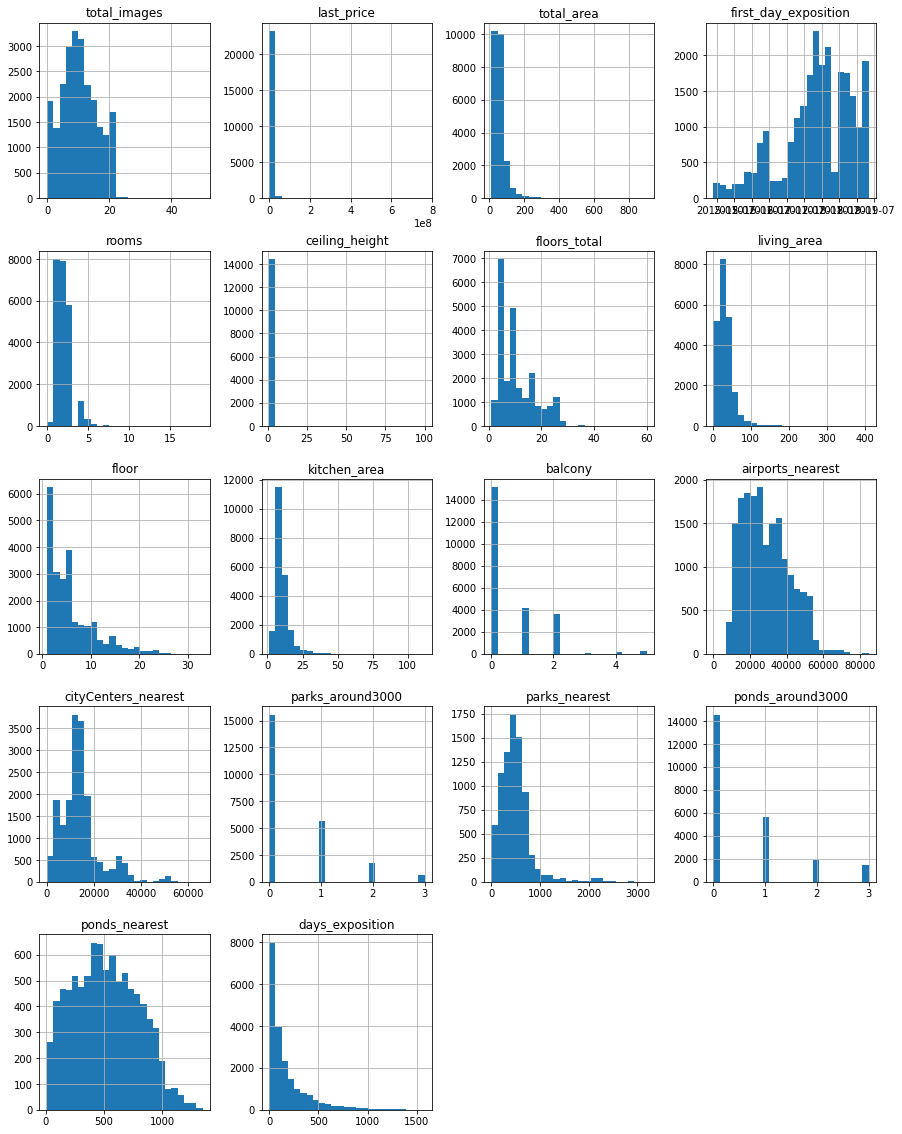

In [15]:
data.hist(figsize=(15, 20), bins=25)

In [16]:
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23565.000000,2.356500e+04,23565.000000,23565.000000,14481.000000,23565.000000,21700.000000,23565.000000,21343.000000,23565.000000,18041.000000,18064.000000,23565.000000,8030.000000,23565.000000,9036.000000,20394.000000
mean,9.878421,6.540058e+06,60.322824,2.070656,2.771283,10.675875,34.454822,5.878124,10.560994,0.593677,28797.082701,14192.656056,0.468831,490.580448,0.589900,518.289509,180.741395
std,5.681156,1.091093e+07,35.657060,1.078591,1.261983,6.594823,22.045359,4.871485,5.900630,0.960660,12632.499735,8613.348153,0.748403,341.572956,0.883966,278.009558,219.732782
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.510000,5.000000,18.600000,2.000000,7.000000,0.000000,18565.000000,9238.000000,0.000000,288.000000,0.000000,293.000000,45.000000
50%,9.000000,4.646000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.100000,0.000000,26757.000000,13096.500000,0.000000,455.000000,0.000000,503.000000,95.000000
75%,14.000000,6.790000e+06,69.700000,3.000000,2.800000,16.000000,42.300000,8.000000,12.000000,1.000000,37273.000000,16285.000000,1.000000,612.000000,1.000000,730.000000,231.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


In [17]:
print(data.isna().sum())

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9084
floors_total                0
living_area              1865
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area             2222
balcony                     0
locality_name               0
airports_nearest         5524
cityCenters_nearest      5501
parks_around3000            0
parks_nearest           15535
ponds_around3000            0
ponds_nearest           14529
days_exposition          3171
edited_locality_name        0
area_type                   0
single_locality_name        0
dtype: int64


**Рассмотрим описание данных столбцов. Нигде нет отрицательных значений, что хорошо.**
**Подробнее рассмотрим столбец с высотой потолков, есть сильно выбивающиеся значения, минимальное 1м и максимальное 100м.**
**Отредактируем значение: те которые больше 20 поделим на 10, так как скорее всего это вещественные числа, а те что меньше 2 и больше 5 заменим медианным значением для каждого населенного пункта 'edited_locality_name'.**

In [18]:
import warnings
warnings.filterwarnings('ignore')

data['ceiling_height'] = data['ceiling_height'].where(data['ceiling_height'] < 20, data['ceiling_height']/10)

for t in data['edited_locality_name'].unique():
    data.loc[(data['edited_locality_name'] == t) & (data['ceiling_height'].isna()), 'ceiling_height'] = \
    data.loc[(data['edited_locality_name'] == t), 'ceiling_height'].median()    

print(data['ceiling_height'].isna().sum())

95


<AxesSubplot:>

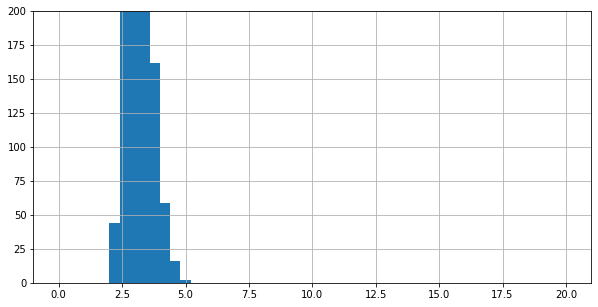

In [19]:
for t in data['edited_locality_name'].unique():
   
        data.loc[(data['edited_locality_name'] == t) & (data['ceiling_height'] < 2) | \
                 (data['edited_locality_name'] == t) & (data['ceiling_height'] > 5), 'ceiling_height'] = \
        data.loc[(data['edited_locality_name'] == t), 'ceiling_height'].median()    
    
plt.ylim(0, 200)
data['ceiling_height'].hist(figsize=(10, 5), bins=50, range=(0, 20))

**Заполним пропущенные значения в столбцах 'airports_nearest' и 'cityCenters_nearest' медианным значением в зависимости от населенного пункта**.

In [20]:
for t in data['edited_locality_name'].unique():
    data.loc[(data['edited_locality_name'] == t) & (data['airports_nearest'].isna()), 'airports_nearest'] = \
    data.loc[(data['edited_locality_name'] == t), 'airports_nearest'].median()

for t in data['edited_locality_name'].unique():
    data.loc[(data['edited_locality_name'] == t) & (data['cityCenters_nearest'].isna()), 'cityCenters_nearest'] = \
    data.loc[(data['edited_locality_name'] == t), 'cityCenters_nearest'].median()

data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height             95
floors_total                0
living_area              1865
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area             2222
balcony                     0
locality_name               0
airports_nearest         5432
cityCenters_nearest      5432
parks_around3000            0
parks_nearest           15535
ponds_around3000            0
ponds_nearest           14529
days_exposition          3171
edited_locality_name        0
area_type                   0
single_locality_name        0
dtype: int64

<AxesSubplot:>

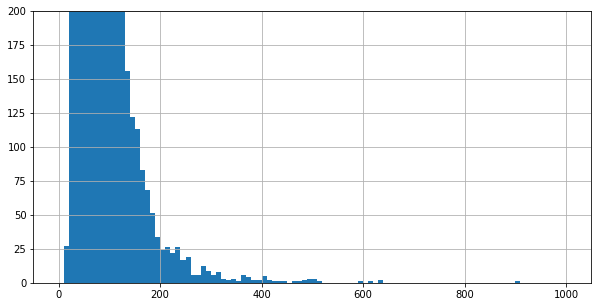

In [21]:
plt.ylim(0, 200)
data['total_area'].hist(figsize=(10, 5), bins=100, range=(0, 1000))

**'total_area' - общая площадь квартиры - основополагающий параметр, он один из главных параметров при выборе квартиры. При рассмотрении гистограммы выявлено, что при площади более 300 м2 количество таких квартир очень мало, тогда примем, что будем рассматривать квартиры с площадью менее 300м2. Удалим из таблицы строки с площадью квартиры более 300м2**

In [22]:
data = data.query('total_area < 300').reset_index(drop=True)
print(len(data))

23502


<AxesSubplot:>

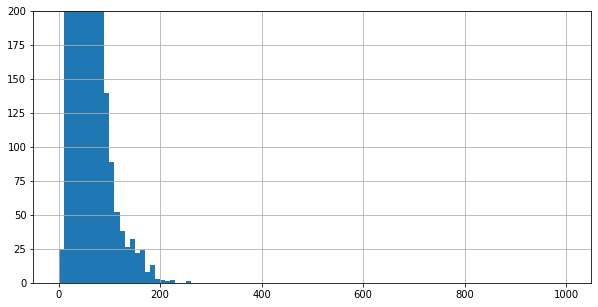

In [23]:
plt.ylim(0, 200)
data['living_area'].hist(figsize=(10, 5), bins=100, range=(0, 1000))

**Также можно исключить квартиры с жилой площадью более 200 м2, которых осталось не так уж и много.**

In [24]:
data = data.query('living_area < 200').reset_index(drop=True)
print(len(data))
data.info()

21644
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21644 entries, 0 to 21643
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          21644 non-null  int64         
 1   last_price            21644 non-null  int64         
 2   total_area            21644 non-null  float64       
 3   first_day_exposition  21644 non-null  datetime64[ns]
 4   rooms                 21644 non-null  int64         
 5   ceiling_height        21571 non-null  float64       
 6   floors_total          21644 non-null  int64         
 7   living_area           21644 non-null  float64       
 8   floor                 21644 non-null  int64         
 9   is_apartment          21644 non-null  bool          
 10  studio                21644 non-null  bool          
 11  open_plan             21644 non-null  bool          
 12  kitchen_area          20855 non-null  float64       
 13  balcony   

array([[<AxesSubplot:title={'center':'total_images'}>,
        <AxesSubplot:title={'center':'last_price'}>,
        <AxesSubplot:title={'center':'total_area'}>,
        <AxesSubplot:title={'center':'first_day_exposition'}>],
       [<AxesSubplot:title={'center':'rooms'}>,
        <AxesSubplot:title={'center':'ceiling_height'}>,
        <AxesSubplot:title={'center':'floors_total'}>,
        <AxesSubplot:title={'center':'living_area'}>],
       [<AxesSubplot:title={'center':'floor'}>,
        <AxesSubplot:title={'center':'kitchen_area'}>,
        <AxesSubplot:title={'center':'balcony'}>,
        <AxesSubplot:title={'center':'airports_nearest'}>],
       [<AxesSubplot:title={'center':'cityCenters_nearest'}>,
        <AxesSubplot:title={'center':'parks_around3000'}>,
        <AxesSubplot:title={'center':'parks_nearest'}>,
        <AxesSubplot:title={'center':'ponds_around3000'}>],
       [<AxesSubplot:title={'center':'ponds_nearest'}>,
        <AxesSubplot:title={'center':'days_exposition'

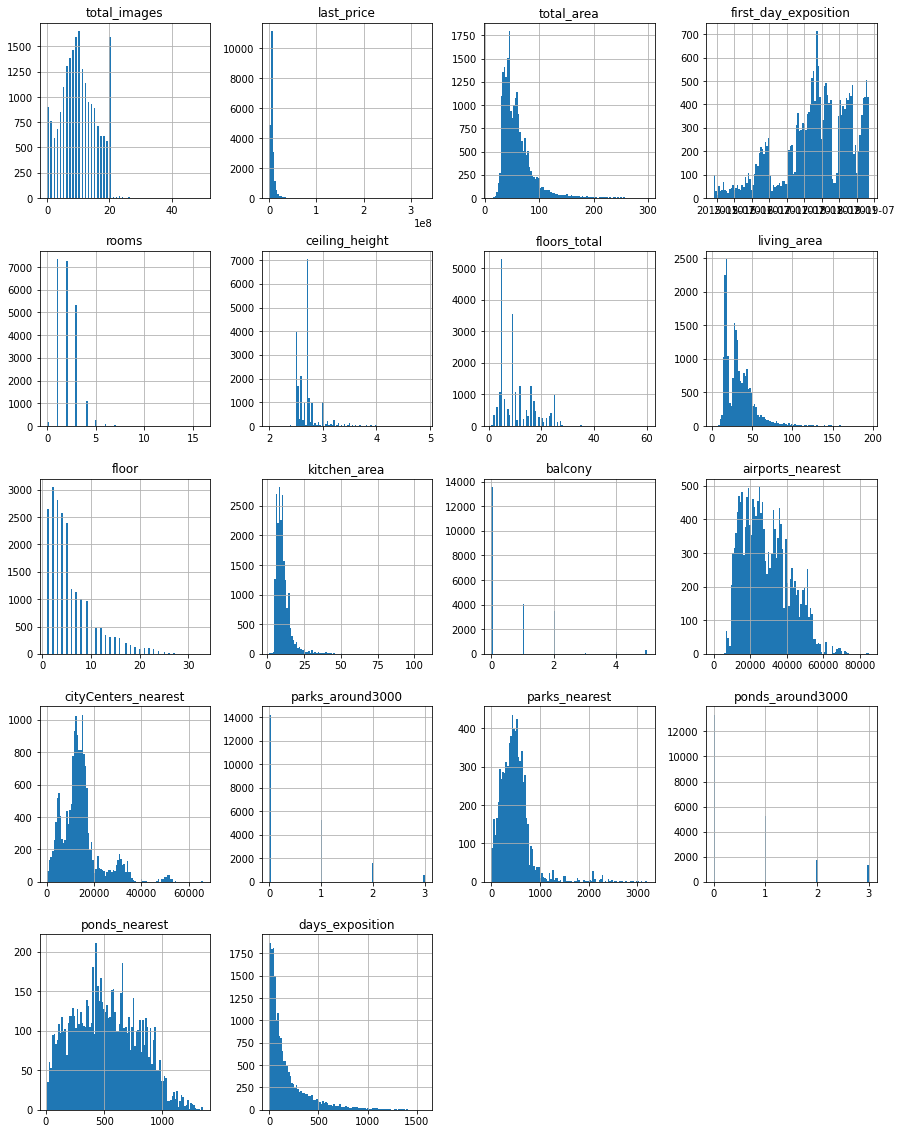

In [25]:
data.hist(figsize=(15, 20), bins=100)

In [26]:
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,21644.000000,2.164400e+04,21644.000000,21644.000000,21571.000000,21644.000000,21644.000000,21644.000000,20855.000000,21644.000000,16812.000000,16812.000000,21644.000000,7430.000000,21644.000000,8322.000000,18677.000000
mean,10.022131,6.269247e+06,59.222684,2.059046,2.702242,10.659536,33.967734,5.879412,10.445845,0.618416,28774.798091,14263.970408,0.471170,488.369717,0.590695,519.881399,184.493013
std,5.673282,7.679441e+06,30.029059,1.044422,0.219872,6.567954,19.593055,4.856616,5.611504,0.968513,12649.240721,8668.020139,0.747804,338.206084,0.883161,277.493688,221.136041
min,0.000000,1.219000e+04,12.000000,0.000000,2.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.450000e+06,40.000000,1.000000,2.550000,5.000000,18.600000,2.000000,7.000000,0.000000,18539.000000,9399.000000,0.000000,288.000000,0.000000,297.000000,44.000000
50%,10.000000,4.650000e+06,52.000000,2.000000,2.700000,9.000000,30.000000,4.000000,9.000000,0.000000,26763.000000,13107.000000,0.000000,452.000000,0.000000,503.000000,101.000000
75%,14.000000,6.700000e+06,69.000000,3.000000,2.700000,16.000000,42.177500,8.000000,12.000000,1.000000,37199.000000,16268.000000,1.000000,610.750000,1.000000,733.000000,238.000000
max,50.000000,3.300000e+08,297.500000,16.000000,4.900000,60.000000,195.000000,33.000000,107.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


**В результате предобработки данных выполнено следующее:**

1) Найдены и заполнены пропуски в столбцах. Наибольшее количество пропусков в столбце 'is_apartment', вероятно это связано с тем пользователи просто не указывали, что квартира не апартамент, заполним пропущенные строки значением False. Также большое количество пропусков есть в столбце 'balcony', вероятно пользователи не заносили значения тaм, где не было балкона, тогда заполним пропуски значением 0 и переведем значения столбца из типа данных object в int. Аналогичная ситуация со столбцами количества парков и водоемов в радиусе 3000 м: 'parks_around3000' и 'ponds_around3000'. Пропуски заполнены значением 0 и измен тип данных с float на int. Также значительное количество пропусков есть в столбцах 'parks_nearest', 'ponds_nearest' (расстояния до ближайшего парка и водоема), однако это связазно с тем, что в населенном пункте нет парков и водоемов. Эта гипотеза проверена выводом на экран сводной таблицы с количеством пропусков по столбцам 'parks_nearest' и 'ponds_nearest' сгруппировав при этом по столбцам 'parks_around3000' и 'ponds_around3000', соответственно. Незначительное количество пропущенных значений в столбцах с названием населенного пункта 'locality_name' и количеством этажей в доме 'floors_total', данными строками можно пренебречь, они удалены из датафрейма.

2) При этом основные причины пропусков по столбцам следующие: Столбец 'is_apartment' - пользователи просто не указывали, что квартира не апартамент, человеческий фактор. Столбцы 'balcony', 'parks_around3000', 'ponds_around3000' - пользователи не заносили значения тaм, где не было балкона, парков и водоемов. Столбцы 'parks_nearest' и 'ponds_nearest' - в населенных пунктах нет парков и водоемов. Столбец 'days_exposition' - объявления еще не сняты. Столбцы 'locality_name' и 'floors_total' - также человечкеский фактор, строки удалены, ввиду малого количества таких строк. Столбцы 'airports_nearest' и 'cityCenters_nearest' - в этих населенных пунктах нет аэропорта и они не являются городами, соответственно. Столбцы 'ceiling_height', 'living_area' - человечекский фактор. Столбец 'kitchen_area' - в квартирах студиях нет перегородок между кухней и жилыми комнатами, а в квартирах открытой планировки еще нет границ кухни, поэтому для данных типов квартир есть пропуски в столбце 'kitchen_area', однако этих значений не много, поэтому основной фактор при возникновении пропусков - человеческий.

3) Для дальнейшего удобства и корректной работы с данными необходимо переводить, после загрузки датафрейма, форматы столбцов в нужные, для того, чтобы не возникало каких-либо ошибок. Кроме того тип данных int занимает меньше памяти, чем float. Выполнена смена форматов данных в столбцах 'balcony', 'first_day_exposition', 'last_price', 'floors_total'. Обявления о продаже рамещали с 27 ноября 2014 г. по 3 мая 2019 г. 

4) Выполнена ликвидация неявных дубликатов. Заменена буква "ё" на "е". Приведены к одному названию типы населенных пунктов где они были прописаны по разному и занесены в новый столбец 'edited_locality_name'. Далее работаем с данным столбцом.

5) Значительное количество пропусков есть в столбцах 'airports_nearest' и 'cityCenters_nearest', эти пропуски заполнены медианным значением перед этим сгруппированы по отредактированному названию населенного пункта. Таким же способом заполнены пропуски в столбце с высотой потолков ('ceiling_height'), вероятнее всего в рамках определенного населенного пункта больше придерживаются одинаковых правил застройки.

5) Исключены редкие и выбивающиеся значения в столбцах 'ceiling_height' (значения больше 20 поделены на 10, значения меньше 2 и больше 5 заменены на медианное значение в зависимости от населенного пункта), 'total_area' > 300 м2, 'living_area' > 200 м2.

In [27]:
len(data)/23699

0.9132874804844087

**В результате предобработки данных осталось 91,3% от превоначальных данных, что приемлемо.**

### Посчитайте и добавьте в таблицу новые столбцы

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21644 entries, 0 to 21643
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          21644 non-null  int64         
 1   last_price            21644 non-null  int64         
 2   total_area            21644 non-null  float64       
 3   first_day_exposition  21644 non-null  datetime64[ns]
 4   rooms                 21644 non-null  int64         
 5   ceiling_height        21571 non-null  float64       
 6   floors_total          21644 non-null  int64         
 7   living_area           21644 non-null  float64       
 8   floor                 21644 non-null  int64         
 9   is_apartment          21644 non-null  bool          
 10  studio                21644 non-null  bool          
 11  open_plan             21644 non-null  bool          
 12  kitchen_area          20855 non-null  float64       
 13  balcony         

**Создаем столбцы:**
- цена одного квадратного метра - 'price_meter';
- день недели публикации объявления (0 — понедельник, 1 — вторник и так далее) - 'weekday';
- месяц публикации объявления - 'month';
- год публикации объявления - 'year';

In [29]:
data['price_meter'] = (data['last_price'] / data['total_area']).round(decimals=2)
data['weekday'] = data['first_day_exposition'].dt.weekday
data['month'] = data['first_day_exposition'].dt.month
data['year'] = data['first_day_exposition'].dt.year

**Разбиваем квартиры по группа в зависимости от этажа на: «первый», «последний», «другой» с помощью функции to_type_floor и записываем название группы в столбец 'type_floor'**

In [30]:
def to_type_floor(row):
    
    floor = row['floor']
    floors_total = row['floors_total']
    
    try:
        if floor == 1:
            return 'первый'
    
        elif floor == floors_total:
            return 'последний'
    
        return 'другой'
    except:
        'Не удалось категоризировать!'

data['type_floor'] = data.apply(to_type_floor, axis=1)

print(data['type_floor'].value_counts()) 

другой       15934
последний     3055
первый        2655
Name: type_floor, dtype: int64


**Переведем расстояние до центра города из метров в километры и занесем в столбец .**

In [31]:
import numpy as np

#data['cityCenters_nearest_km'] = (data['cityCenters_nearest'] / 1000).ceil(decimals=0)
data['cityCenters_nearest_km'] = (data['cityCenters_nearest'] / 1000).apply(np.ceil)
print(data['cityCenters_nearest_km'].head())

0    17.0
1    19.0
2    14.0
3     9.0
4     NaN
Name: cityCenters_nearest_km, dtype: float64


### Проведите исследовательский анализ данных

**4.1 Изучим по отдельности данные столбцов**

<AxesSubplot:ylabel='Frequency'>

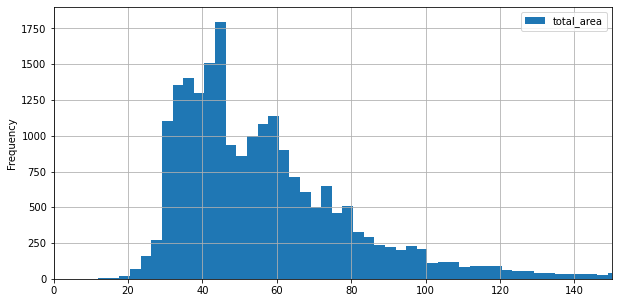

In [32]:
data.plot(y='total_area', kind='hist', bins=100, grid=True, ylim=(0, 1900), xlim=(0,150), figsize=(10, 5))
                                                                                                

**Основное количество квартир с общей площадью от 25 до 80 м2. Наибольшее количество квартир с общей площадью 40-45 м2.**

<AxesSubplot:ylabel='Frequency'>

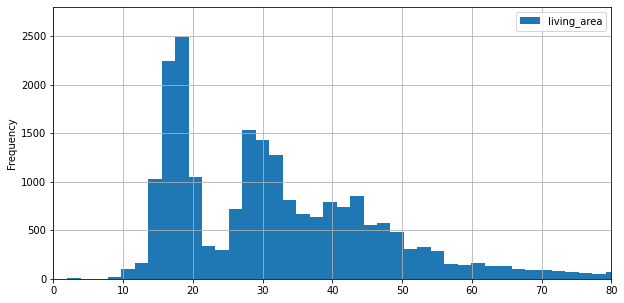

In [33]:
data.plot(y='living_area', kind='hist', bins=100, grid=True, ylim=(0, 2800), xlim=(0,80), figsize=(10, 5))

**По жилой площаде выделяется 2 группы квартир с жилой площадью 15-20 м2 и 25-50 м2**

<AxesSubplot:ylabel='Frequency'>

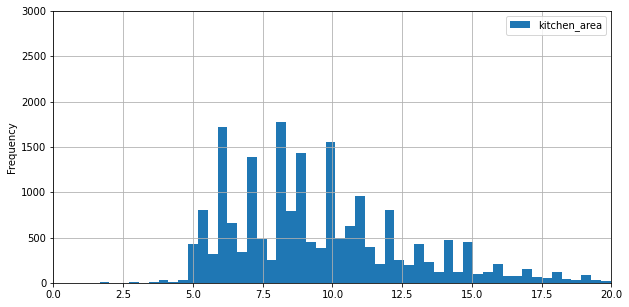

In [34]:
data.plot(y='kitchen_area', kind='hist', bins=300, grid=True, ylim=(0, 3000), xlim=(0,20), figsize=(10, 5))

**Основное количество квартир с площадью кухни от 5 до 12 м2**

<AxesSubplot:ylabel='Frequency'>

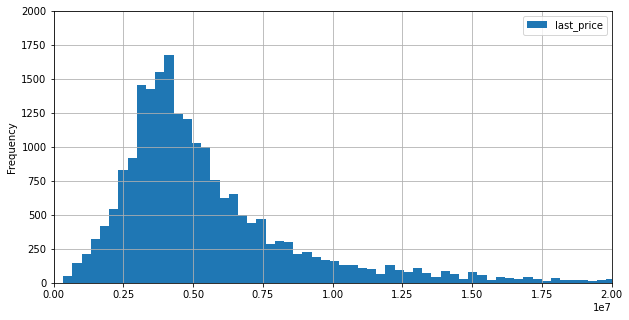

In [35]:
data.plot(y='last_price', kind='hist', bins=1000, grid=True, ylim=(0, 2000), xlim=(0, 20000000), figsize=(10, 5))

**Стоимость большинства квартир варьируется от 2,5 млн до 5 млн рублей.**

array([ 3,  1,  2,  4,  5,  6,  0, 11,  7,  8, 10,  9, 16, 14])

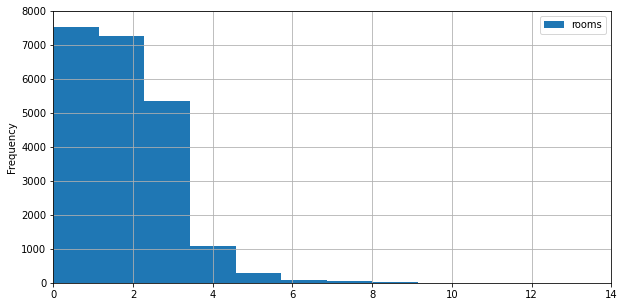

In [36]:
data.plot(y='rooms', kind='hist', bins=14, grid=True,  ylim=(0, 8000), xlim=(0, 14), figsize=(10, 5))
data['rooms'].unique()

**Значительное количетсво квартир с количеством комнат 0, это квартиры студии или открытой планировки ('studio', 'open_plan'). Также большое количество квартир с с 1 и 2-мя комнатами. Чуть меньше квартир с 3-мя комнатами. Квартир с 4-мя и более комнатами наименьшее количество. Вероятно квартиры студии, открытой планировки одно- и двух- комнатные чаще покупают для перепродажи, а также для последующего расширения жилплощади.**

<AxesSubplot:ylabel='Frequency'>

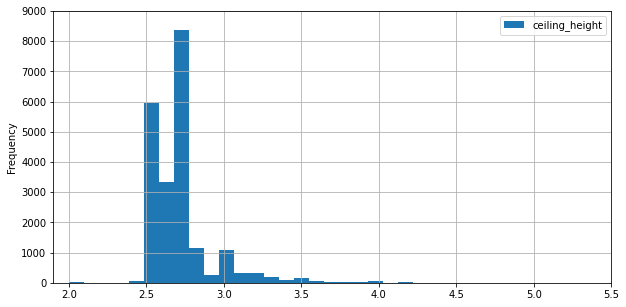

In [37]:
data.plot(y='ceiling_height', kind='hist', bins=30, grid=True,  ylim=(0, 9000), xlim=(1.9, 5.5), figsize=(10, 5))

**Наибольшее количество квартир с высотой потолков от 2,5 до 2,7 м, что является минимальным значением прописаным в регламентирующих документах по строительству многоквартирных домов.**

<AxesSubplot:ylabel='Frequency'>

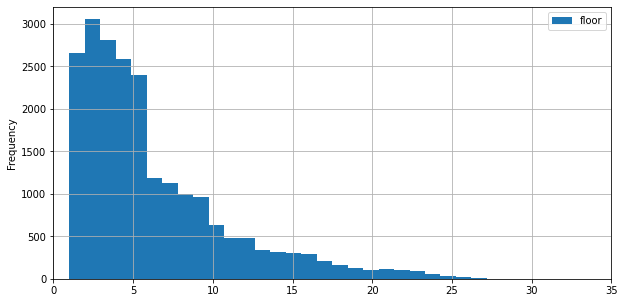

In [38]:
data.plot(y='floor', kind='hist', bins=33, grid=True,  ylim=(0, 3200), xlim=(0, 35), figsize=(10, 5))

**Наибольшее количество продаваемых квартир с этажами от 1 до 6 этажа**

<AxesSubplot:xlabel='type_floor'>

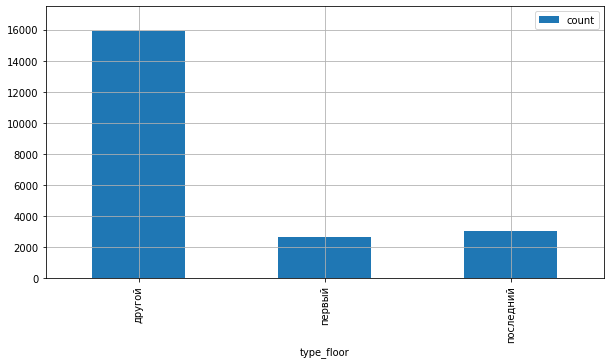

In [39]:
data.groupby('type_floor').agg({'floor': ['count']}).plot(y='floor', kind='bar', grid=True,  ylim=(0, 17500), figsize=(10, 5))
#data.plot(y='type_floor', kind='hist', bins=33, grid=True,  ylim=(0, 3200), xlim=(0, 35), figsize=(10, 5))

**Очевидно наибольшее количество продаваемых квартит в группе "другой". Однако стоит обратить внимание на то что квартиры на последних этажах продают чаще, чем на первых.**

<AxesSubplot:ylabel='Frequency'>

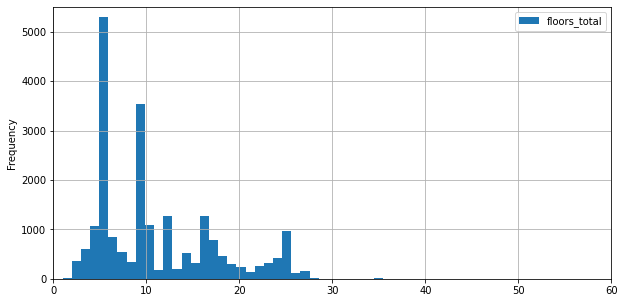

In [40]:
data.plot(y='floors_total', kind='hist', bins=60, grid=True,  ylim=(0, 5500), xlim=(0, 60), figsize=(10, 5))

**Чаще всего продают квартиры в 5-ти и 10-ти этажных домах**

<AxesSubplot:ylabel='Frequency'>

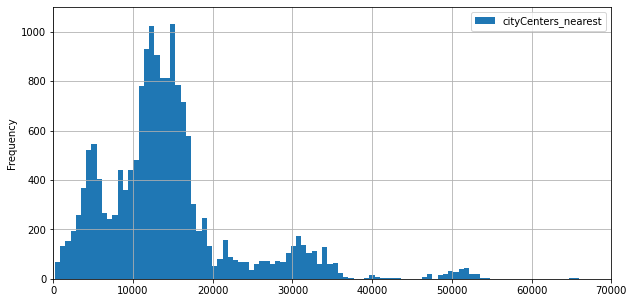

In [41]:
data.plot(y='cityCenters_nearest', kind='hist', bins=100, grid=True,  ylim=(0, 1100), xlim=(0, 70000), figsize=(10, 5))

**В основном продают квартиры от 10 до 18 тыс. м от центра города**

<AxesSubplot:ylabel='Frequency'>

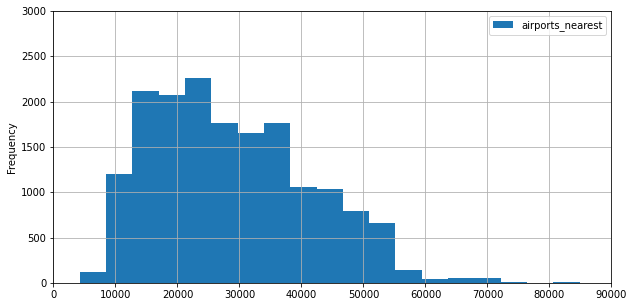

In [42]:
data.plot(y='airports_nearest', kind='hist', bins=20, grid=True,  ylim=(0, 3000), xlim=(0, 90000), figsize=(10, 5))

**Чаще всего продают квартиры в 13-ти - 38-ми тыс. м от аэропорта**

<AxesSubplot:ylabel='Frequency'>

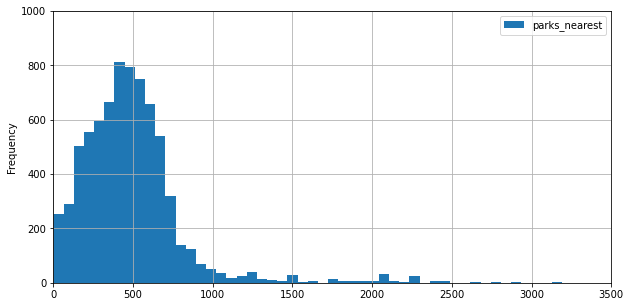

In [43]:
data.plot(y='parks_nearest', kind='hist', bins=50, grid=True,  ylim=(0, 1000), xlim=(0, 3500), figsize=(10, 5))

**Чаще всего расстояние от продаваемых квартир до ближайшего парка составляет от 800 до 600 м**

<AxesSubplot:ylabel='Frequency'>

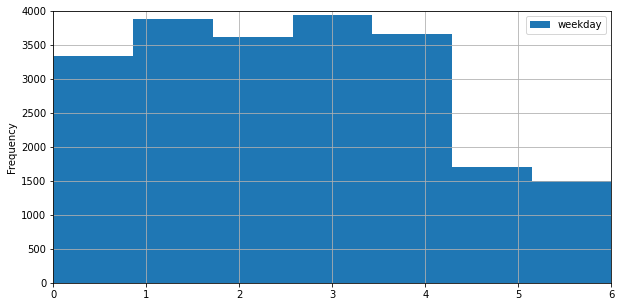

In [44]:
data.plot(y='weekday', kind='hist', bins=7, grid=True,  ylim=(0, 4000), xlim=(0, 6), figsize=(10, 5))

**Чаще всего объявления о продаже квартир публикуют в будние дни, а чаще всего во вторник и четверг.**

<AxesSubplot:ylabel='Frequency'>

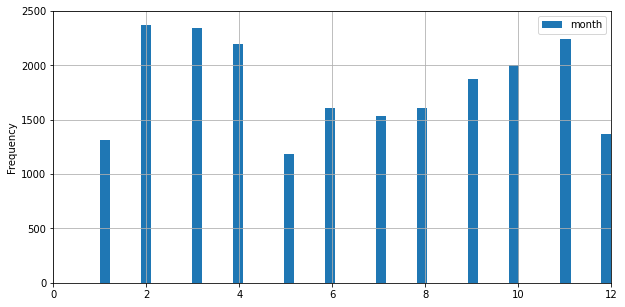

In [45]:
data.plot(y='month', kind='hist', bins=50, grid=True,  ylim=(0, 2500), xlim=(0, 12), figsize=(10, 5))

**Чаще всего объявления о продаже квартир размещают с февраля по апрель, а также осенью с сеентября по ноябрь. С мая по август и  с декабря по январь активность в продажах квартир снижается вероятно из-за периода отпусков.**

**Изучены данные столбцов:**
- Основное количество квартир с общей площадью от 25 до 80 м2. Наибольшее количество квартир с общей площадью 40-45 м2.
- По жилой площаде выделяется 2 группы квартир с жилой площадью 15-20 м2 и 25-50 м2.
- Основное количество квартир с площадью кухни от 5 до 12 м2.
- Стоимость большинства квартир варьируется от 2,5 млн до 5 млн рублей.
- Значительное количетсво квартир с количеством комнат 0, это квартиры студии или открытой планировки ('studio', 'open_plan'). Также большое количество квартир с 1 и 2-мя комнатами. Чуть меньше квартир с 3-мя комнатами. Квартир с 4-мя и более комнатами наименьшее количество. Вероятно квартиры студии, открытой планировки, одно- и двух- комнатные чаще покупают для перепродажи, а также для последующего расширения жилплощади.
- Наибольшее количество квартир с высотой потолков от 2,5 до 2,7 м, что является минимальным значением прописаным в регламентирующих документах по строительству многоквартирных домов.
- Наибольшее количество продаваемых квартир с этажами от 1 до 6 этажа.
- Очевидно наибольшее количество продаваемых квартит в группе "другой". Однако стоит обратить внимание на то что квартиры на последних этажах продают чаще, чем на первых.
- Чаще всего продают квартиры в 5-ти и 10-ти этажных домах.
- В основном продают квартиры от 10 до 18 тыс. м от центра города.
- Чаще всего продают квартиры в 13-ти - 38-ми тыс. м от аэропорта.
- Чаще всего расстояние от продаваемых квартир до ближайшего парка составляет от 600 до 800 м.
- Чаще всего объявления о продаже квартир публикуют в будние дни и чаще всего во вторник и четверг.
- Чаще всего объявления о продаже квартир размещают с февраля по апрель, а также осенью с сентября по ноябрь. С мая по август и с декабря по январь активность в продажах квартир снижается вероятно из-за периода отпусков.

**4.2 Изучим скорость продажи квартир**

<AxesSubplot:ylabel='Frequency'>

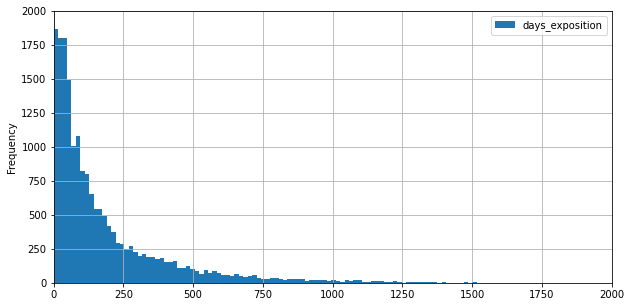

In [46]:
data.plot(y='days_exposition', kind='hist', bins=100, grid=True,  ylim=(0, 2000), xlim=(0, 2000), figsize=(10, 5))

count    18677.000000
mean       184.493013
std        221.136041
min          1.000000
25%         44.000000
50%        101.000000
75%        238.000000
max       1580.000000
Name: days_exposition, dtype: float64


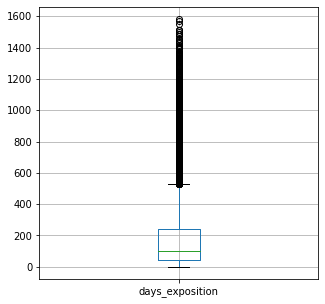

In [47]:
print(data['days_exposition'].describe())
data.boxplot(column='days_exposition', figsize=(5, 5))
plt.show()

**Распределение количества дней размешения обявлений является распределением Пуассона. Значения более 529 являются выбросами. Рассматривая гистограмму примем верхнюю границу дней размещения объявлений в 1000 дней, такие продажи будем считать слишком долгими. Быстрыми - до 50 дней. Создадим новую переменную good_data и потом запишем в нее срез таблицы data с количеством дней размещения объявлений меньше 1000. Также подробно рассмотрим данные количества дней размешения объявлений на отрезке 0-100 дней.**

**Рассмотрим подробнее данные количества дней размешения объявлений на отрезке 0-100 дней.**

<AxesSubplot:ylabel='Frequency'>

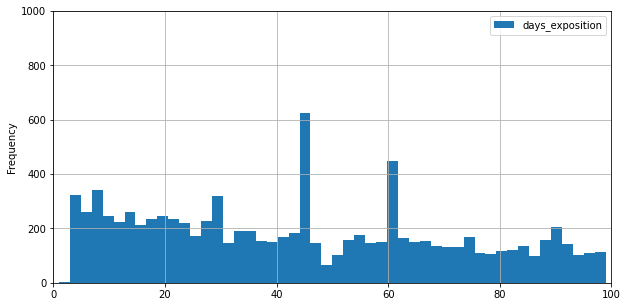

In [48]:
data100d = data.query('days_exposition < 100')
data100d.plot(y='days_exposition', kind='hist', bins=50, grid=True,  ylim=(0, 1000), xlim=(0, 100), figsize=(10, 5))

**При рассмотрении частотной гистограммы видны пики при 45, 60 и 90 днях. Также заметил есть пик в значении 30, тогда когда заканчивается период платной подписки, возможно забывают положить деньги на карту и подписка не продляется. Удалим данные значения из нашего датасета.**

good_data  18425
good_data  17188
count    17188.000000
mean       179.590936
std        193.168007
min          1.000000
25%         42.000000
50%        111.000000
75%        245.000000
max        999.000000
Name: days_exposition, dtype: float64


<AxesSubplot:ylabel='Frequency'>

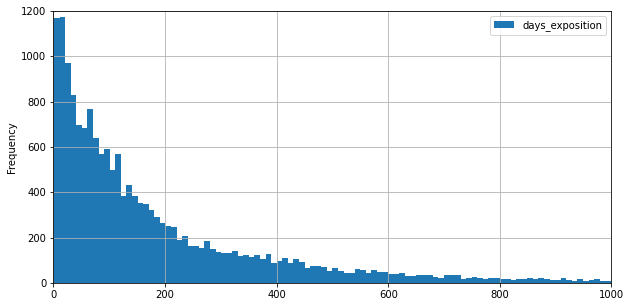

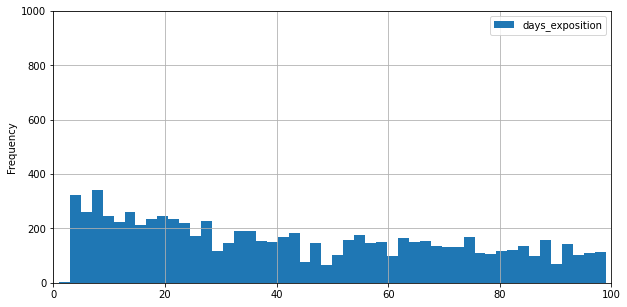

In [50]:
good_data = data.query('days_exposition < 1000')
print('good_data ', len(good_data))

good_data = good_data.query('not(29<days_exposition<31) and not(45<days_exposition<46) and not(59<days_exposition<61) \
and not(90<days_exposition<91)').reset_index(drop=True)
print('good_data ', len(good_data))


print(good_data['days_exposition'].describe())
good_data.plot(y='days_exposition', kind='hist', bins=100, grid=True,  ylim=(0, 1200), xlim=(0, 1000), figsize=(10, 5))


data100dd = good_data.query('days_exposition < 100')
data100dd.plot(y='days_exposition', kind='hist', bins=50, grid=True,  ylim=(0, 1000), xlim=(0, 100), figsize=(10, 5))

**Изучено, как быстро продавались квартиры**

Распределение количества дней размешения обявлений является распределением Пуассона. Среднее значение составляет 180, а медиана - 111. Значения более 529 являются выбросами. По результату рассмотрения гистограммы принята верхняя граница дней размещения объявлений в 1000 дней, такие продажи будем считать слишком долгими. Быстрыми - до 50 дней. При этом, создана новая переменная normal_data и в нее записан срез таблицы data с количеством дней размещения объявлений меньше 1000 и исключены строки со временем размещения объявлений 30, 45, 60 и 90 дней. Исключив значения 30, 45, 60 и 90 мы избавились от выбросов в значениях в диапазоне до 100 дней.   

**4.3 Изучим факторы больше всего влияющие на общую (полную) стоимость объекта**

0.668732891957924


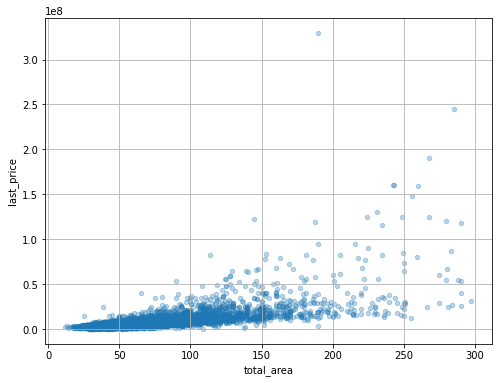

In [51]:
good_data.plot(x='total_area', y='last_price', kind='scatter', alpha=0.3, figsize=(8, 6), grid=True)
print(good_data['total_area'].corr(good_data['last_price']))

**При увеличении общей площади квартиры увеличивается и ее цена, коэффициент корреляции для текущей выборки составляет 0,67, что говорит о хорошей зависимости данных параметров.**

0.5800711787000192


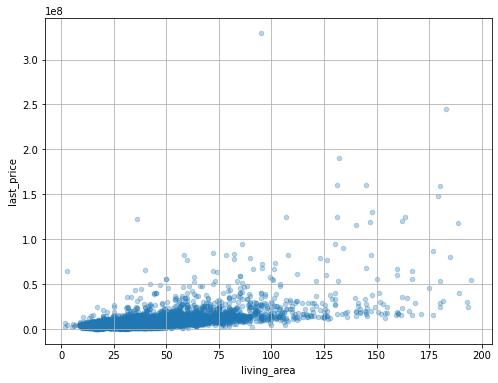

In [52]:
good_data.plot(x='living_area', y='last_price', kind='scatter', alpha=0.3, figsize=(8, 6), grid=True)
print(good_data['living_area'].corr(good_data['last_price']))

**При увеличении жилой площади квартиры также увеличивается и ее цена, коэффициент корреляции для текущей выборки меньше и составляет 0,58, что говорит уже не о такой сильной зависимости данных параметров.**

0.5021442668995729


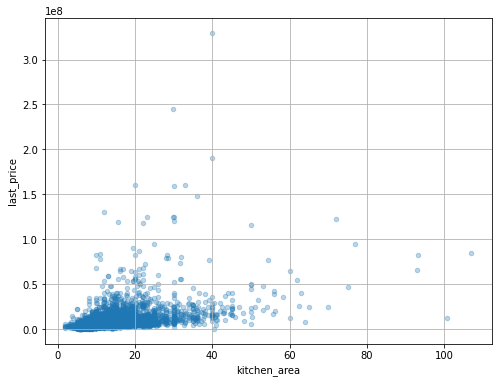

In [53]:
good_data.plot(x='kitchen_area', y='last_price', kind='scatter', alpha=0.3, figsize=(8, 6), grid=True)
print(good_data['kitchen_area'].corr(good_data['last_price']))

**При коэффициенте корреляции 0,50 уже о зависимости говорить не приходится. Площадь кухни не влияет на цену квартиры.**

0.3893169398810881


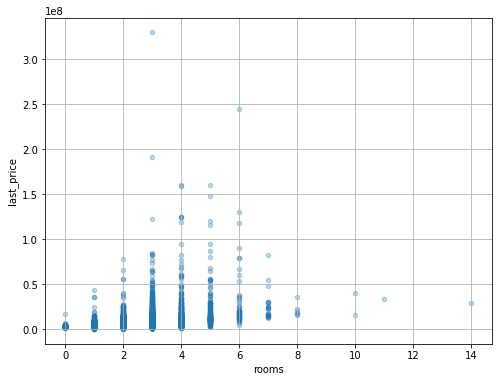

In [54]:
good_data.plot(x='rooms', y='last_price', kind='scatter', alpha=0.3, figsize=(8, 6), grid=True)
print(good_data['rooms'].corr(good_data['last_price']))

**Явно, зависимости цены от количества комнат в квартире нет**

<AxesSubplot:xlabel='type_floor'>

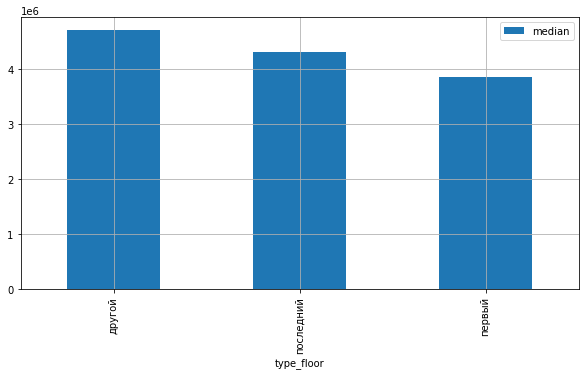

In [55]:
good_data.groupby('type_floor').agg({'last_price': ['median']})['last_price'] \
.sort_values(by='median', ascending=False).plot(y='median', kind='bar', figsize=(10, 5), grid=True)

**Исходя из данной гистограммы, основанной на сводной таблице по типу этажа и медианной цене квартиры, можно сделать вывод о наличии зависимости между ценой квартиры и типом этажа. Самые дешевые квартиры на первых этажах, на последних - несколько дороже и самые большие цены на остальных этажах**

-0.009201162614724543


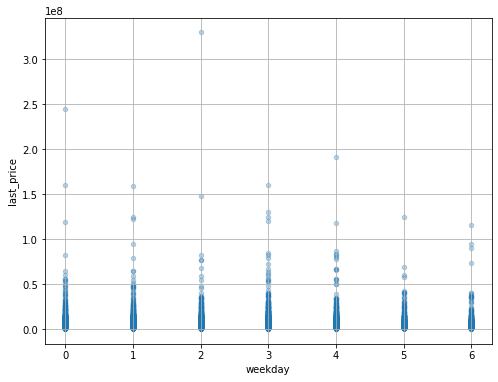

In [56]:
good_data.plot(x='weekday', y='last_price', kind='scatter', alpha=0.3, figsize=(8, 6), grid=True)
print(good_data['weekday'].corr(good_data['last_price']))

<AxesSubplot:xlabel='weekday'>

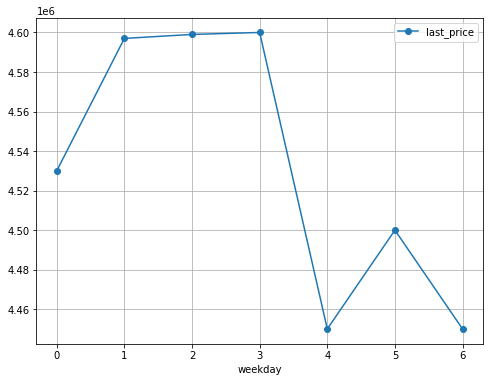

In [57]:
good_data.pivot_table(index='weekday', values='last_price', aggfunc='median').plot(grid=True, style='o-', figsize=(8, 6))

**По результату построения графика медианных значений цены в зависимости от дня недели отмечается, что c понедельника по четверг выкладывают объявления о продаже более дорогой недвижимости, чем в остальные дни.**

<AxesSubplot:xlabel='month'>

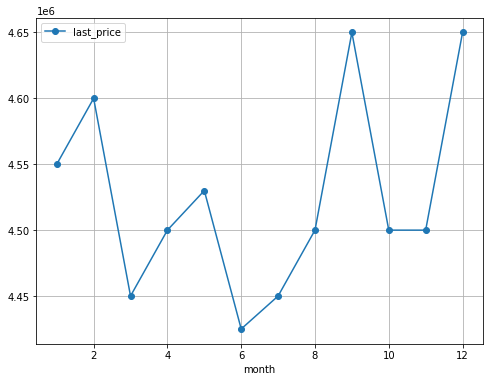

In [58]:
good_data.pivot_table(index='month', values='last_price', aggfunc='median').plot(grid=True, style='o-', figsize=(8, 6))

**В январе, апреле-мае, августе и октябре-ноябре продаваемая недвижимость в цене примерно одинакова. В марте и июне-июле - при продаже квартир закладывают наименьшую цену. В феврале, сентябре и декабре при выкладывании объявлений закладывают наибольшую цену квартир.**

<AxesSubplot:xlabel='year'>

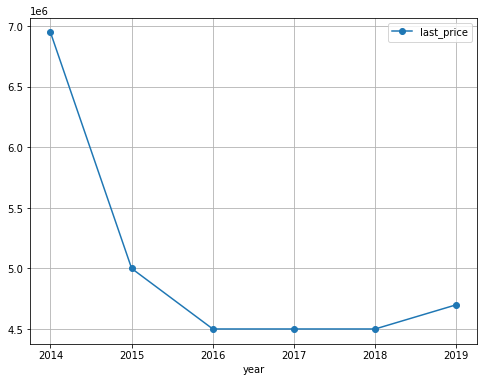

In [59]:
good_data.pivot_table(index='year', values='last_price', aggfunc='median').plot(grid=True, style='o-', figsize=(8, 6))

**Цены на квартиры с 2014 по 2016 гг упали почти в 2 раза, в 2016-2018 гг цены стабилизировались, а в 2019 отмечается незначительное восстановление.**

**Факторы больше всего влияющие на общую (полную) стоимость объекта**
- При увеличении общей площади квартиры увеличивается и ее цена, коэффициент корреляции для текущей выборки составляет 0,67, что говорит о хорошей зависимости данных параметров.
- При увеличении жилой площади квартиры также увеличивается и ее цена, коэффициент корреляции для текущей выборки меньше и составляет 0,58, что говорит уже не о такой сильной зависимости данных параметров.
- При коэффициенте корреляции 0,50 уже о зависимости говорить не приходится. Площадь кухни не влияет на цену квартиры.
- Зависимости цены от количества комнат в квартире не отмечается.
- Выявлена зависимость между ценой квартиры и типом этажа. Самые дешевые квартиры на первых этажах, на последних - несколько дороже и самые большие цены на остальных этажах.
- По результату построения графика медианных значений цены в зависимости от дня недели отмечается, что c понедельника по четверг выкладывают объявления о продаже более дорогой недвижимости, чем в остальные дни.
- В январе, апреле-мае, августе и октябре-ноябре продаваемая недвижимость в цене примерно одинакова. В марте и июне-июле - при продаже квартир закладывают наименьшую цену. В феврале, сентябре и декабре при выкладывании объявлений закладывают наибольшую цену квартир.
- Цены на квартиры с 2014 по 2016 гг упали почти в 2 раза, в 2016-2018 гг цены стабилизировались, а в 2019 отмечается незначительное восстановление.

**4.4 Средняя цена одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений.**

In [64]:
avg_price_data = good_data.groupby('edited_locality_name').agg({'price_meter': ['count', 'mean']})['price_meter'] \
.sort_values(by='count', ascending=False).query('count > 154')
print(avg_price_data)
print(avg_price_data.sort_values(by='mean', ascending=False))

                      count           mean
edited_locality_name                      
Санкт-Петербург       11595  111279.794705
поселок Мурино          459   86239.233290
деревня Кудрово         359   94494.314568
поселок Шушары          339   78142.455929
Всеволожск              294   68817.543197
Колпино                 270   74885.176778
Пушкин                  262  102965.518702
поселок Парголово       247   90108.342186
Гатчина                 234   67405.141880
Петергоф                155   82742.521548
                      count           mean
edited_locality_name                      
Санкт-Петербург       11595  111279.794705
Пушкин                  262  102965.518702
деревня Кудрово         359   94494.314568
поселок Парголово       247   90108.342186
поселок Мурино          459   86239.233290
Петергоф                155   82742.521548
поселок Шушары          339   78142.455929
Колпино                 270   74885.176778
Всеволожск              294   68817.543197
Гатчина    

**Средняя цена одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений.**
- Определены 10 населенных пунктов с самым большим количеством объявлений - Санкт-Петербург, поселок Мурино, деревня Кудрово, поселок Шушары, Всеволожск, Колпино, Пушкин, поселок Парголово, Гатчина и Петергоф. Наибольшая средняя цена за квадратный метр в Санкт-Петербурге и составляет 111279 руб. Наименьшая средняя цена за квадратный метр в Гатчине и составляет 67405 руб.

**4.5 Средняя цена каждого километра.**

,last_price
cityCenters_nearest_km,
1.0,2.106374e+07
2.0,1.707534e+07
3.0,1.472033e+07
4.0,1.053458e+07
5.0,1.167335e+07
6.0,1.285812e+07
7.0,1.168996e+07
8.0,1.151854e+07
9.0,7.817913e+06


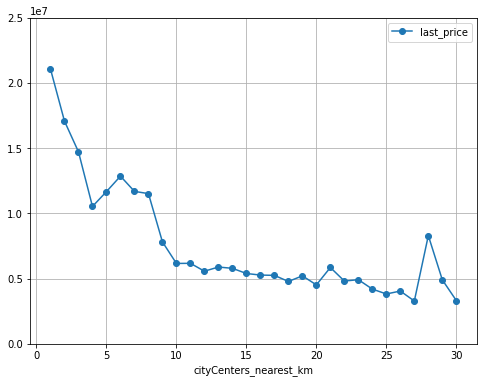

In [61]:
good_data_spb = good_data.query('edited_locality_name == "Санкт-Петербург"')
good_data_spb.pivot_table(index='cityCenters_nearest_km', values='last_price', aggfunc='mean') \
.plot(grid=True, style='o-', ylim=(0, 25000000), figsize=(8, 6))
good_data_spb.pivot_table(index='cityCenters_nearest_km', values='last_price', aggfunc='mean')

**Средняя цена каждого километра. Зависимость стоимости объектов от расстояния до центра города**
- Зависимость средней цены от расстояния до центра Санкт-Петербурга не линейная, при приближении к центру стоимость квартир возрастает.
- В диапазоне 30-10 км до центра средняя цена квартир постепенно возрастает с 3,3 млн руб. до 6,2 млн. руб.
- В диапазоне от 10 до 1 км отмечается интенсивный рост цены при приближении к центру города с 6,2 млн руб. до почти 21,0 млн руб.

### Общий вывод

**В результате предобработки данных выполнено следующее:**

1) Найдены и заполнены пропуски в столбцах. Наибольшее количество пропусков в столбце 'is_apartment', вероятно это связано с тем, что пользователи просто не указывали, что квартира не апартамент, пропущенные строки заполнены значением False. Также большое количество пропусков есть в столбце 'balcony', вероятно пользователи не заносили значения тaм, где не было балкона, данные пропуски заполнены значением 0 и значения столбца переведены из типа данных object в int. Аналогичная ситуация со столбцами количества парков и водоемов в радиусе 3000 м: 'parks_around3000' и 'ponds_around3000'. Пропуски заполнены значением 0 и измен тип данных с float на int. Также значительное количество пропусков есть в столбцах 'parks_nearest', 'ponds_nearest' (расстояния до ближайшего парка и водоема), однако это связазно с тем, что в населенном пункте нет парков и водоемов. Эта гипотеза проверена выводом на экран сводной таблицы с количеством пропусков по столбцам 'parks_nearest' и 'ponds_nearest' сгруппировав при этом по столбцам 'parks_around3000' и 'ponds_around3000', соответственно. Незначительное количество пропущенных значений в столбцах с названием населенного пункта 'locality_name' и количеством этажей в доме 'floors_total', данными строками можно пренебречь, они удалены из датафрейма.

2) Основные причины пропусков по столбцам следующие: Столбец 'is_apartment' - пользователи просто не указывали, что квартира не апартамент, человеческий фактор. Столбцы 'balcony', 'parks_around3000', 'ponds_around3000' - пользователи не заносили значения тaм, где не было балкона, парков и водоемов. Столбцы 'parks_nearest' и 'ponds_nearest' - в населенных пунктах нет парков и водоемов. Столбец 'days_exposition' - объявления еще не сняты. Столбцы 'locality_name' и 'floors_total' - также человеческий фактор, строки удалены, ввиду малого количества таких строк. Столбцы 'airports_nearest' и 'cityCenters_nearest' - в этих населенных пунктах нет аэропорта и они не являются городами, соответственно. Столбцы 'ceiling_height', 'living_area' - человечекский фактор. Столбец 'kitchen_area' - в квартирах студиях нет перегородок между кухней и жилыми комнатами, а в квартирах открытой планировки еще нет границ кухни, поэтому для данных типов квартир есть пропуски в столбце 'kitchen_area', однако этих значений не много, поэтому основной фактор при возникновении пропусков - человеческий.

3) Для дальнейшего удобства и корректной работы с данными необходимо переводить, после загрузки датафрейма, форматы столбцов в нужные, для того, чтобы не возникало каких-либо ошибок. Кроме того, например, тип данных int занимает меньше памяти, чем float. Выполнена смена форматов данных в столбцах 'balcony', 'first_day_exposition', 'last_price', 'floors_total'. Отмечается, что обявления о продаже рамещали с 27 ноября 2014 г. по 3 мая 2019 г. 

4) Выполнена ликвидация неявных дубликатов. Заменена буква "ё" на "е" в названиях населенных пунктов в столбце locality_name. Приведены к одному названию типы населенных пунктов где они были прописаны по разному и занесены в новый столбец 'edited_locality_name'. Дальнейший анализ выполнен с использованием данного столбца.

5) Значительное количество пропусков есть в столбцах 'airports_nearest' и 'cityCenters_nearest', эти пропуски заполнены медианным значением перед этим сгруппированы по отредактированному названию населенного пункта. Таким же способом заполнены пропуски в столбце с высотой потолков ('ceiling_height'), вероятнее всего в рамках определенного населенного пункта больше придерживаются одинаковых правил застройки.

6) Исключены редкие и выбивающиеся значения в столбцах 'ceiling_height' (значения больше 20 поделены на 10, значения меньше 2 и больше 5 заменены на медианное значение в зависимости от населенного пункта), 'total_area' > 300 м2, 'living_area' > 200 м2.

**Для дальнейшей работы добавлены столбцы:**

- цена одного квадратного метра 'price_meter';
- день недели публикации объявления (0 — понедельник, 1 — вторник и так далее) 'weekday';
- месяц публикации объявления 'month';
- год публикации объявления 'year';
- тип этажа квартиры (значения — «первый», «последний», «другой») 'type_floor';
- расстояние до центра города в километрах (переведите из м в км и округлите до целых значений) 'cityCenters_nearest_km'.

**Изучены данные столбцов:**

- Основное количество квартир с общей площадью от 25 до 80 м2. Наибольшее количество квартир с общей площадью 40-45 м2.
- По жилой площаде выделяется 2 группы квартир с жилой площадью 15-20 м2 и 25-50 м2.
- Основное количество квартир с площадью кухни от 5 до 12 м2.
- Стоимость большинства квартир варьируется от 2,5 млн до 5 млн рублей.
- Значительное количетсво квартир с количеством комнат 0, это квартиры студии или открытой планировки ('studio', 'open_plan'). Также большое количество квартир с 1 и 2-мя комнатами. Чуть меньше квартир с 3-мя комнатами. Квартир с 4-мя и более комнатами наименьшее количество. Вероятно квартиры студии, открытой планировки, одно- и двух- комнатные чаще покупают для перепродажи, а также для последующего расширения жилплощади.
- Наибольшее количество квартир с высотой потолков от 2,5 до 2,7 м, что является минимальным значением прописаным в регламентирующих документах по строительству многоквартирных домов.
- Наибольшее количество продаваемых квартир с этажами от 1 до 6 этажа.
- Очевидно наибольшее количество продаваемых квартит в группе "другой". Однако стоит обратить внимание на то что квартиры на последних этажах продают чаще, чем на первых.
- Чаще всего продают квартиры в 5-ти и 10-ти этажных домах.
- В основном продают квартиры от 10 до 18 тыс. м от центра города.
- Чаще всего продают квартиры в 13-ти - 38-ми тыс. м от аэропорта.
- Чаще всего расстояние от продаваемых квартир до ближайшего парка составляет от 600 до 800 м.
- Чаще всего объявления о продаже квартир публикуют в будние дни и чаще всего во вторник и четверг.
- Чаще всего объявления о продаже квартир размещают с февраля по апрель, а также осенью с сентября по ноябрь. С мая по август и с декабря по январь активность в продажах квартир снижается вероятно из-за периода отпусков.

**Изучено, как быстро продавались квартиры**

- Распределение количества дней размешения обявлений является распределением Пуассона. Среднее значение составляет 180, а медиана - 111. Значения более 529 являются выбросами. По результату рассмотрения гистограммы принята верхняя граница дней размещения объявлений в 1000 дней, такие продажи будем считать слишком долгими. Быстрыми - до 50 дней. При этом, создана новая переменная normal_data и в нее записан срез таблицы data с количеством дней размещения объявлений меньше 1000 и исключены строки со временем размещения объявлений 30, 45, 60 и 90 дней. Исключив значения 30, 45, 60 и 90 мы избавились от выбросов в значениях в диапазоне до 100 дней.   

**Факторы больше всего влияющие на общую (полную) стоимость объекта**

- При увеличении общей площади квартиры увеличивается и ее цена, коэффициент корреляции для текущей выборки составляет 0,67, что говорит о хорошей зависимости данных параметров.
- При увеличении жилой площади квартиры также увеличивается и ее цена, коэффициент корреляции для текущей выборки меньше и составляет 0,58, что говорит уже не о такой сильной зависимости данных параметров.
- При коэффициенте корреляции 0,50 уже о зависимости говорить не приходится. Площадь кухни не влияет на цену квартиры.
- Зависимости цены от количества комнат в квартире не отмечается.
- Выявлена зависимость между ценой квартиры и типом этажа. Самые дешевые квартиры на первых этажах, на последних - несколько дороже и самые большие цены на остальных этажах.
- По результату построения графика медианных значений цены в зависимости от дня недели отмечается, что c понедельника по четверг выкладывают объявления о продаже более дорогой недвижимости, чем в остальные дни.
- В январе, апреле-мае, августе и октябре-ноябре продаваемая недвижимость в цене примерно одинакова. В марте и июне-июле - при продаже квартир закладывают наименьшую цену. В феврале, сентябре и декабре при выкладывании объявлений закладывают наибольшую цену квартир.
- Цены на квартиры с 2014 по 2016 гг упали почти в 2 раза, в 2016-2018 гг цены стабилизировались, а в 2019 отмечается незначительное восстановление.

**Средняя цена одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений.**

- Определены 10 населенных пунктов с самым большим количеством объявлений - Санкт-Петербург, поселок Мурино, деревня Кудрово, поселок Шушары, Всеволожск, Колпино, Пушкин, поселок Парголово, Гатчина и Петергоф. Наибольшая средняя цена за квадратный метр в Санкт-Петербурге и составляет 111279 руб. Наименьшая средняя цена за квадратный метр в Гатчине и составляет 67405 руб.

**Средняя цена каждого километра. Зависимость стоимости объектов от расстояния до центра города**

- Зависимость средней цены от расстояния до центра Санкт-Петербурга не линейная, при приближении к центру стоимость квартир возрастает.
- В диапазоне 30-10 км до центра средняя цена квартир постепенно возрастает с 3,3 млн руб. до 6,2 млн. руб.
- В диапазоне от 10 до 1 км отмечается интенсивный рост цены при приближении к центру города с 6,2 млн руб. до почти 21,0 млн руб.